In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
sns.set(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})

In [5]:
cols = ["OpenTime",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "CloseTime",
        "Quote-asset-volume",
        "Number-of-trades",
        "Taker-buy-base-asset-volume",
        "Taker-buy-quote-asset-volume",
        "Ignore"]

In [6]:
with open("dotusdt-15m-1000.json") as f:
    dotUsdtRaw = json.load(f)
    dotUsdt = pd.DataFrame(dotUsdtRaw, columns = cols)
    dotUsdt["Close"] = dotUsdt["Close"].apply(lambda x: float(x))

In [7]:
with open("btcusdt-15m-1000.json") as f:
    btcUsdtRaw = json.load(f)
    btcUsdt = pd.DataFrame(btcUsdtRaw, columns = cols)
    btcUsdt["Close"] = btcUsdt["Close"].apply(lambda x: float(x))

In [8]:
dotUsdt.head(2)

,OpenTime,Open,High,Low,Close,Volume,CloseTime,Quote-asset-volume,Number-of-trades,Taker-buy-base-asset-volume,Taker-buy-quote-asset-volume,Ignore
0,1615448700000,36.91280000,37.00050000,36.36800000,36.4138,148479.65000000,1615449599999,5438447.56961300,11073,49652.79000000,1820471.29973500,0
1,1615449600000,36.41380000,36.46930000,35.94150000,36.1849,486713.97000000,1615450499999,17606371.26274900,17896,164479.71000000,5951335.09712700,0


In [9]:
btcUsdt.head(2)

,OpenTime,Open,High,Low,Close,Volume,CloseTime,Quote-asset-volume,Number-of-trades,Taker-buy-base-asset-volume,Taker-buy-quote-asset-volume,Ignore
0,1615532400000,57061.52000000,57061.53000000,56661.00000000,56679.10,741.31496600,1615533299999,42090581.45334719,20538,341.32606600,19378132.97719620,0
1,1615533300000,56679.10000000,56850.51000000,56456.71000000,56753.25,1105.52369400,1615534199999,62633620.67164635,24429,609.51484300,34535690.09956243,0


In [26]:
from sklearn.cluster import KMeans
class CryptoAgent:
    def __init__(self, pivots=3, pivotDiff=0.005, profitLimit=0.015):
        self.pivots = pivots
        self.pivotDiff = pivotDiff
        self.profitLimit = profitLimit
        self.prices = np.array([])
        self.events = []
        self.position = None
        self.positionHistory = []
        self.lastPrice = 0
        self.logs = []

    def feed(self, data):
        self.prices = np.concatenate((self.prices, data))
        self.margin = len(self.prices)
        self.kmeans = KMeans(n_clusters=self.pivots, random_state=0)
        self.kmeans.fit(self.prices.reshape(-1, 1))
        self.pivots = self.kmeans.cluster_centers_.reshape(-1)
        self.pivotHighs = self.pivots * (1 + self.pivotDiff)
        self.pivotLows = self.pivots * (1 - self.pivotDiff)
        self.lastPrice = self.prices[-1]

    def findLastEvent(self, pivot):
        for e in self.events[::-1]:
            if e["pivot"] == pivot:
                return e
        return None

    def log(self, msg):
        self.logs.append(msg)
    
    def observe(self, price):
        self.prices = np.append(self.prices, price)
        d = price
        for pivot in self.pivots:
            if d > pivot and self.lastPrice < pivot:
                e = self.findLastEvent(pivot)
                if e is None or e["kind"] != "UP":
                    self.events.append({
                        "pivot": pivot,
                        "kind": "UP"
                    })
                    self.log("saw %f while going up" % (pivot))
            elif d < pivot and self.lastPrice > pivot:
                e = self.findLastEvent(pivot)
                if e is None or e["kind"] != "DOWN":
                    self.events.append({
                        "pivot": pivot,
                        "kind": "DOWN"
                    })
                    self.log("saw %f while going down" % (pivot))
        for high in self.pivotHighs:
            if d > high and self.lastPrice < high:
                if self.position is None:
                    self.position = {
                        "type": "BUY",
                        "price": high,
                        "index": len(self.prices) - 1
                    }
                self.log("breaking up %f " % high)
        for low in self.pivotLows:
            if d < low and self.lastPrice > low:
                if self.position is not None:
                    self.positionHistory.append(self.position)
                    self.positionHistory.append({
                        "type": "SELL",
                        "price": low,
                        "index": len(self.prices) - 1
                    })
                    self.positionHistory.append({
                        "type": "REPORT",
                        "profit": (low - self.position["price"]) / self.position["price"]
                    })

                    self.position = None
                self.log("breaking down %f" % low)
        if self.position is not None and ((d - self.position["price"])/self.position["price"]) >= self.profitLimit:
            self.positionHistory.append(self.position)
            self.positionHistory.append({
                "type": "SELL",
                "price": d,
                "index": len(self.prices) - 1
            })
            self.positionHistory.append({
                "type": "REPORT",
                "profit": (d - self.position["price"]) / self.position["price"]
            })
            self.position = None
        self.lastPrice = d
    
    def plotPivots(self):
        sns.lineplot(data=self.prices, color="#FFF689", lw=1)
        plt.axvline(self.margin, color="#9EE493", linestyle=":")
        for pivot in self.pivots:
            plt.axhline(pivot, color="#ff0099", linestyle="--", lw=1)
            plt.axhline(pivot * 1.005, color="#3DB1F5", linestyle="--", lw=0.6)
            plt.axhline(pivot * 0.995, color="#3DB1F5", linestyle="--", lw=0.6)

    def plotOrders(self):
        sns.lineplot(data=self.prices, color="#FFF689", lw=1)
        for position in self.positionHistory:
            if position["type"] == "BUY":
                plt.axvline(position["index"], color="#9EE493", lw=1)
            if position["type"] == "SELL":
                plt.axvline(position["index"], color="#3DB1F5", lw=1)

    def report(self):
        overall = 1
        failed = 0
        success = 0
        for position in self.positionHistory:
            if position["type"] == "REPORT":
                overall *= (1 + position["profit"])
                if position["profit"] > 0:
                    success += 1
                else:
                    failed += 1
        print("Overall profit: %f" % (overall - 1))
        print("Sucessful positions: %d | Failed Positions: %d" % (success, failed))

In [29]:
agent = CryptoAgent()
prices = dotUsdt["Close"].to_numpy()
agent.feed(prices[:200])
for d in prices[200:]:
    agent.observe(d)

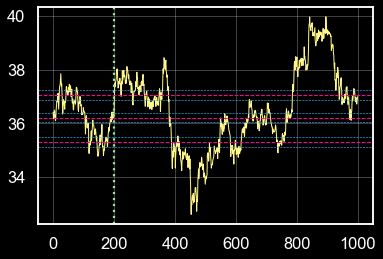

In [30]:
agent.plotPivots()

In [33]:
agent.report()

Overall profit: 0.153909
Sucessful positions: 14 | Failed Positions: 11


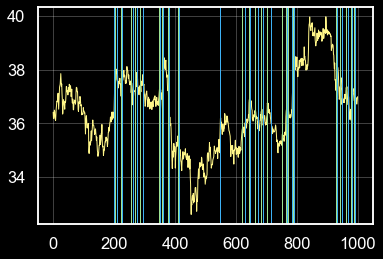

In [34]:
agent.plotOrders()

In [35]:
agent = CryptoAgent()
prices = btcUsdt["Close"].to_numpy()
agent.feed(prices[:200])
for d in prices[200:]:
    agent.observe(d)

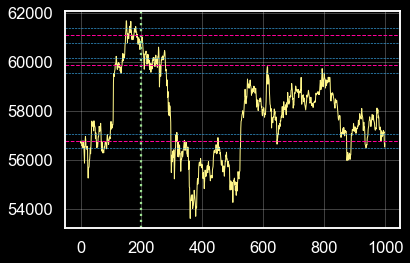

In [36]:
agent.plotPivots()

In [37]:
agent.report()

Overall profit: 0.024019
Sucessful positions: 4 | Failed Positions: 4


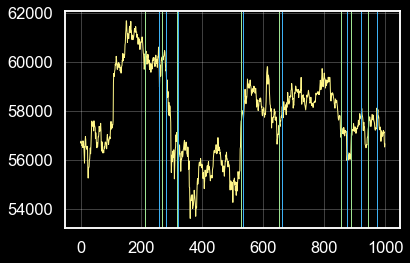

In [38]:
agent.plotOrders()